<h2><center><font color='blue'> Calculation of Well Head Protection Areas using Capture Zone Analysis </center></h2>

<h3><font color='teal'><center> Venki Uddameri, Ph.D., P.E.

<hr>

The use of Theis solution for capture zone analysis does not account for the impacts of regional groundwater flow gradients.  As such, other tools for better delineation of capture zones are available.  A schematic description of the capture zones is shown below




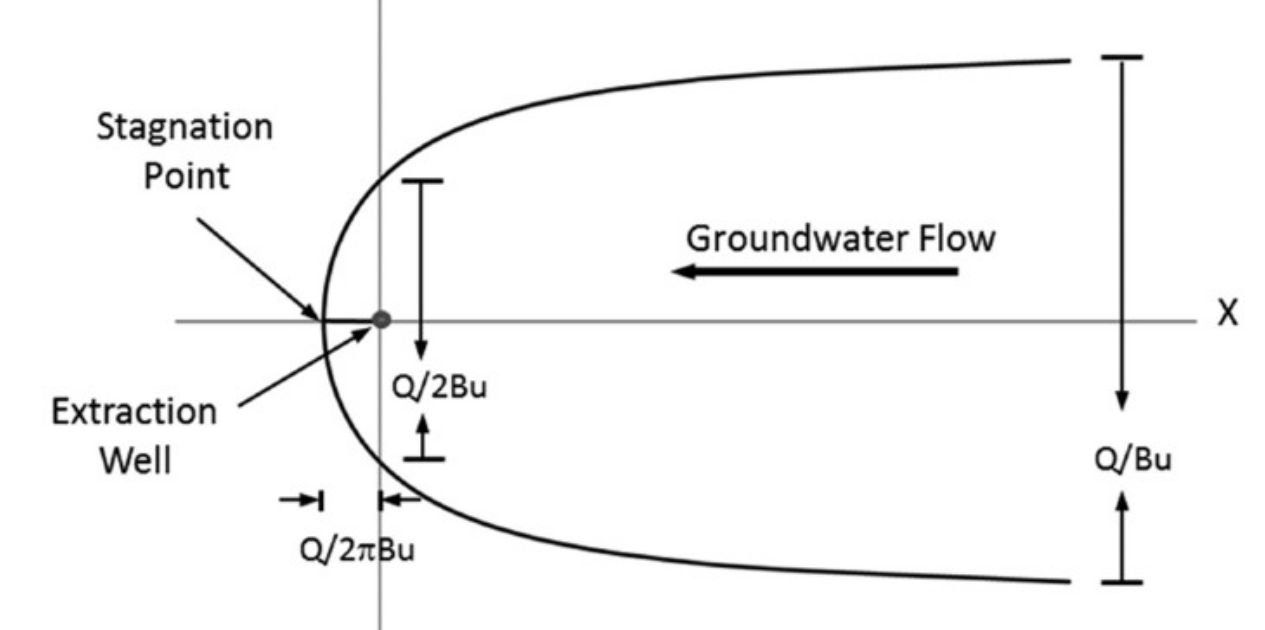

The figure above assumes the well is at a location (0,0).  The stagnation point refers to the point on the X-axis (downgradient of the flow) till which the pumping effects are felt.  The maximum width of the cpature zone along the Y-axis is also given.  We can also obtain the outer curve of the capture zone using the following equations.

$x_s = -\frac{Q}{2\pi BU} $  Where $x_s$ is the stagnation point.  Note as the well is at the origin, the stagnation point is negative

$y_{max} = \pm \frac{Q}{BU} $

For the capture zone boundary, the relationship between x and y is given as follows:

$ x = -\frac{y}{tan\left(\frac{2 \pi UB y}{Q}\right)} $

Where, U is the Darcy velocity (K.i) (ft/d); K is the hydraulic conductivity (ft/d); i is regional groundwater flow gradient.  Q is the pumping rate (ft$^3$/d); B is the aquifer thickness.  Note the product BU can also be written as the product Ti (where T is the aquifer transmissivity ft$^2$/d).  Note any set of consistent units can be used.  **If Albert Equal Area Conic** projection is used then the use of m for length dimension may come handy.  

<h4> Workflow

The computation entails the following steps.
<ol>
<li> Select the dimensions of study (L in m; t in Days); Q will be $m^3/d$ and BU = Ti = $m^2/d$ </li>
<li> Select projection to use.  Albers Equal Area Conic CONUS, NAD 83 (2011); EPSG:6350 </li>
<li> Select the Well Location (get lat-lon coordinates) convert to AEA projection </li>
<li> Extract Transmissivity values at the well (from interpolated T gpkg file) </li>
<li> Obtain the mean water levels (computed earlier) for wells in a gpkg fle </li>
<li> Convert the meam water levels file to AEA projection and compute X and Y coordinates </li>
<li> Compute the regional groundwater flow using linear regression of Hydraulic Head (from MSL) against X and Y </li>
<li> Use the coefficients of X and Y to obtain the gradients along X and Y axis and compute resultant gradient </li>
<li> Compute the capture zone polygon in model coordinates (well is at 0,0) </li>
<li> Convert the capture zone polygon to AEA projection coordinates use suitable transformation </li>
<li> Transform the coordinates obtained in the above step such that X-axis is oriented along the groundwater flow direction</li>
<li> Create a shapely polygon (object) of the capture zone.  Export to a gpkg file
<li> Overlay the capture zone polygon onto the Jefferson County Map; Embellish the plot as appropriate.
</ol>

<h4> Import Libraries

In [ ]:
# Import Libraries
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import geopandas as gp
import matplotlib_map_utils as mu # To draw north arrow
import statsmodels.api as sm
from matplotlib_scalebar.scalebar import ScaleBar # to draw scalebar
from shapely.geometry import Point

<h4> Set Working Directory

In [88]:
path = "E:\\Inclass2\\Inclassdata"
os.chdir(path)

In [91]:
import geopandas as gp

1. Select the Well Location (get lat-lon coordinates) convert to AEA projection

In [96]:
# Step 1: Load well location data
wellloc = gp.read_file('pwells2.gpkg')
wellloc.head()

,StateWellNumber,County,LongitudeDD,LatitudeDD,LandSurfaceElevationMethod,WellDepth,WaterElevation,DepthFromLSD,T_SQFTDay,T_GPD_ft,top_1,bot_1,bot_2,bot_3,bot_4,bot_5,bot_6,geometry
0,6154901,Jefferson,-94.266112,30.134722,Interpolated From Topo Map,21.0,23.100000,6.900000,3358,25120,7.84802,-7.15198,-423.0,-789.0,-986.0,-1533.111,-2221.0,POINT (-94.26611 30.13472)
1,6154905,Jefferson,-94.271389,30.159167,Interpolated From Topo Map,572.0,-25.338571,51.338571,3352,25072,7.76283,-7.23717,-408.0,-750.0,-943.0,-1469.906,-2155.0,POINT (-94.27139 30.15917)
2,6161602,Jefferson,-94.407223,30.073611,Interpolated From Topo Map,300.0,29.300000,6.700000,3190,23864,11.34370,-3.65630,-422.0,-844.0,-1033.0,-1528.316,-2262.0,POINT (-94.40722 30.07361)
3,6162303,Jefferson,-94.275555,30.089167,Interpolated From Topo Map,102.0,30.000000,8.000000,3336,24952,11.82590,-3.17410,-438.0,-848.0,-1054.0,-1640.914,-2336.0,POINT (-94.27556 30.08917)
4,6162305,Jefferson,-94.291667,30.096389,Interpolated From Topo Map,208.0,31.000000,8.000000,3315,24797,11.60230,-3.39770,-431.0,-818.0,-1030.0,-1596.809,-2295.0,POINT (-94.29167 30.09639)


2. Extract Transmissivity values at the well (from interpolated T gpkg file)
   
3. Obtain the mean water levels (computed earlier) for wells in a gpkg fle

4. Convert the meam water levels file to AEA projection and compute X and Y coordinate

In [135]:
# Extract the values from the T_SFTDay column (Interpolated T)
Tvalues = gp.read_file('Tvalues1.gpkg')

# Display the extracted values
Tvalues = Tvalues.to_crs(epsg=6350)
print("CRS of Tvalues:", Tvalues.crs)

CRS of Tvalues: EPSG:6350


In [143]:
# Extract Transmissivity (T) and Location of well
Tcols = Tvalues[['WellID', 'Lon', 'Lat', 'T', 'geometry']]

# Mean Water Level File
wcol = wellloc[['WellDepth', 'WaterElevation', 'DepthFromLSD']]

In [145]:
# Combining Transmissitivity, Well Location and Mean Water Level into one file:
combined_df = pd.concat([Tcols, wcol], axis=1)

# Save the combined DataFrame to a GPKG file
combined_df.to_file("combined_df.gpkg", layer='combined_data', driver="GPKG")

combined_df.head()

,WellID,Lon,Lat,T,geometry,WellDepth,WaterElevation,DepthFromLSD
0,1,-94.071944,30.065000,55200,POINT (185672.228 778471.944),21.0,23.100000,6.900000
1,2,-94.035278,30.066667,13100,POINT (189198.915 778729.203),572.0,-25.338571,51.338571
2,3,-94.046389,30.064167,18000,POINT (188134.791 778429.734),300.0,29.300000,6.700000
3,4,-94.073889,30.060556,18300,POINT (185495 777974.972),102.0,30.000000,8.000000
4,5,-94.073889,30.066389,16300,POINT (185481.879 778622.265),208.0,31.000000,8.000000


In [139]:
Tvalues.head()
print("CRS of combined_df:", combined_df.crs)

CRS of combined_df: EPSG:6350


5. Compute the regional groundwater flow using linear regression of Hydraulic Head (from MSL) against X and Y

6. Use the coefficients of X and Y to obtain the gradients along X and Y axis and compute resultant gradient

In [165]:
# Extract X and Y coordinates from the geometry column for each well location
combined_df['x'] = combined_df.geometry.apply(lambda geom: geom.x)
combined_df['y'] = combined_df.geometry.apply(lambda geom: geom.y)

# Confirm extraction
print(combined_df[['WellID', 'geometry', 'x', 'y']].head())

import statsmodels.api as sm

# Prepare data for regression
X = combined_df[['x', 'y']]
X = sm.add_constant(X)  # Adds a constant term to the predictor
y = combined_df['WaterElevation']  # Use the column name for mean water levels

# Perform linear regression 
model = sm.OLS(y, X).fit()

# Print regression summary
print(model.summary())

# Add the regression results to the GeoDataFrame
combined_df['predicted_water_elevation'] = model.predict(X)

# Save the updated GeoDataFrame to a new GeoPackage file
combined_df.to_file('Newcombined_df.gpkg', driver='GPKG')

   WellID                       geometry              x              y
0       1  POINT (185672.228 778471.944)  185672.228311  778471.943892
1       2  POINT (189198.915 778729.203)  189198.915007  778729.203087
2       3  POINT (188134.791 778429.734)  188134.791426  778429.734156
3       4      POINT (185495 777974.972)  185495.000399  777974.972279
4       5  POINT (185481.879 778622.265)  185481.879425  778622.264874
                            OLS Regression Results                            
Dep. Variable:         WaterElevation   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                 -0.173
Method:                 Least Squares   F-statistic:                    0.4099
Date:                Tue, 05 Nov 2024   Prob (F-statistic):              0.681
Time:                        22:19:36   Log-Likelihood:                -38.347
No. Observations:                   9   AIC:                             82.69
Df Residuals:        

C:\Users\User\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=9 observations were given.
  return hypotest_fun_in(*args, **kwds)


7. Compute the capture zone polygon in model coordinates (well is at 0,0)

8. Convert the capture zone polygon to AEA projection coordinates use suitable transformation

9. Transform the coordinates obtained in the above step such that X-axis is oriented along the groundwater flow direction


In [171]:
# Use the coefficients from the regression model
coeff_x = model.params['x']
coeff_y = model.params['y']

# Calculate the gradients along the X and Y axes
gradient_x = coeff_x
gradient_y = coeff_y

# Compute the resultant gradient
resultant_gradient = np.sqrt(gradient_x**2 + gradient_y**2)
print(f"Gradient along X-axis: {gradient_x}")
print(f"Gradient along Y-axis: {gradient_y}")
print(f"Resultant Gradient: {resultant_gradient}")

Gradient along X-axis: -0.0006904438377065345
Gradient along Y-axis: 0.0008025299661408214
Resultant Gradient: 0.0010586628545391186


In [208]:
# Function to compute capture zone polygon in model coordinates with well at 0,0)
def capture_zone(Q, T, B, gradient):
    # Stagnation Point Distance
    x_s = Q / (2 * np.pi * T * gradient)
    # Maximum Width of the Capture Zone
    y_m = Q / (T * gradient)
    
    x = np.linspace(-x_s, x_s, 100)
    y = y_m * np.sqrt(1 - (x / x_s) ** 2)
    return x, y

In [ ]:
from shapely.geometry import Point
from shapely.geometry import Polygon
from matplotlib import pyplot as plt

10. Create a shapely polygon (object) of the capture zone. Export to a gpkg file

11. Overlay the capture zone polygon onto the Jefferson County Map; Embellish the plot as appropriate.

In [241]:
# Example values (replace with your actual data)
Q = 1000  # Pumping rate (m³/day)
T = 55200 # T value From T.gpkg 
B = 20    # Aquifer thickness (m)

# Ensure all example values are of type float 
Q = float(Q) 
T = float(T) 
B = float(B)

# Calculate capture zone coordinates
x, y = capture_zone(Q, T, B, resultant_gradient)
capture_zone_points = [Point(x[i], y[i]) for i in range(len(x))] + [Point(x[i], -y[i]) for i in range(len(x)-1, -1, -1)]
capture_zone_polygon = Polygon([[point.x, point.y] for point in capture_zone_points])

In [ ]:
# Create GeoDataFrame for the capture zone polygon
capture_zone_gdf = gp.GeoDataFrame([1], geometry=[capture_zone_polygon], crs="EPSG:6350")

# Plot the capture zone
fig, ax = plt.subplots()
capture_zone_gdf.boundary.plot(ax=ax, color='blue', linewidth=2)
plt.title('Capture Zone')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.show()

In [ ]:
# Load the Jefferson Map
JeffersonCounty ='JeffersonWGS84.gpkg'

# Overlay the capture zone polygon onto the Jefferson County Map
fig, ax = plt.subplots()
jeffersonCounty_gdf.boundary.plot(ax=ax, color='black', linewidth=1, label='Jefferson County')
capture_zone_gdf.boundary.plot(ax=ax, color='blue', linewidth=2, label='Capture Zone')

# Embellish the plot
plt.title('Capture Zone Overlay on Jefferson County Map')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.legend()
plt.grid(True)
plt.show()